# LIBRARIES

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import yaml
import time
import os

## Import torch
import torch
from torch.utils.data import TensorDataset, DataLoader

from neuralsens.partial_derivatives import calculate_second_partial_derivatives_mlp

## Import Voronoi
from scipy.spatial import Voronoi
from scipy.io.arff import loadarff
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0,'../Scripts/')

import DNN
import train
import data_load_lipschitz
import Utils

import Utilities as Utilities
import utilities_voronoi
import utilities_lipschitz
import importlib
import MonoNN

from utilities_voronoi import *
importlib.reload(utilities_voronoi)
importlib.reload(Utilities)
importlib.reload(DNN)
importlib.reload(train)
importlib.reload(data_load_lipschitz)
importlib.reload(Utils)
importlib.reload(MonoNN)

from data_load_lipschitz import data_load_lipschitz
from data_load_lipschitz import generate_data_Neumann
from train import train
from DNN import DNN

# DATA VISUALIZATION

**ESL DESCRIPTION**

Employee Selection (ESL) This data set contains profiles of applicants for certain industrial
jobs. The values of the four input attributes were determined by expert psychologists based
upon psychometric test results and interviews with the candidates. The output is an overall
score on an ordinal scale between 1 and 9, corresponding to the degree of suitability of
each candidate to this type of job.



In [9]:
##### LOAD DATA
raw_data = loadarff('../Data/ESL.arff')
df = pd.DataFrame(raw_data[0])
print(len(df))

488


In [10]:
## Find the maximum and minimum of each column of the df
max_values = df.iloc[:,:].max()
min_values = df.iloc[:,:].min()
print(max_values)
print(min_values)


in1     9.0
in2     9.0
in3     8.0
in4     8.0
out1    9.0
dtype: float64
in1     0.0
in2     0.0
in3     2.0
in4     2.0
out1    1.0
dtype: float64


# TRAIN TEST SPLIT

In [11]:
def normalize(tensor, min_val=None, max_val=None, mode='normalize'):
    if mode == 'normalize':
        if min_val is None:
            min_val, _ = torch.min(tensor, dim=0)
        if max_val is None:
            max_val, _ = torch.max(tensor, dim=0)
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
        return normalized_tensor, min_val, max_val
    elif mode == 'unnormalize':
        if min_val is None or max_val is None:
            raise ValueError("For unnormalization, min_val and max_val must be provided")
        unnormalized_tensor = tensor * (max_val - min_val) + min_val
        return unnormalized_tensor
    else:
        raise ValueError("Not a valid mode. Choose either 'normalize' or 'unnormalize'")

In [12]:
input_scaler = MinMaxScaler()
cols_selected = [0,1,2,3]

# Adjust and transform the input data
X = df.iloc[:,cols_selected].values
X_tensor = torch.tensor(X, dtype=torch.float)

# Ajustar y transformar los datos de salida
y = df.iloc[:,-1].values.reshape(-1, 1)
#y = df_data[['mpg']].values
y_tensor = torch.tensor(y, dtype=torch.float)
y_tensor,min_val,max_vale = normalize(y_tensor,min_val=1,max_val=9,mode='normalize')
X_tensor,min_val,max_vale  = normalize(X_tensor,min_val=0,max_val=9,mode='normalize')

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.25, random_state=2023)

## Divide again X_train y X_train and X_val
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.25, random_state=2023)

X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float)

# Define the path to the folder
folder_path = '../Data'

# Check if the folder exists
if not os.path.exists(folder_path):
    # If it doesn't exist, create it
    os.makedirs(folder_path)
# Guardar los datos
torch.save(X_train_tensor,'../Data/X_train_data.pt')
torch.save(X_test_tensor,'../Data/X_test_data.pt')
torch.save(y_train_tensor,'../Data/y_train_data.pt')
torch.save(y_test_tensor,'../Data/y_test_data.pt')
torch.save(X_val_tensor,'../Data/X_val_data.pt')
torch.save(y_val_tensor,'../Data/y_val_data.pt')

# Convertir los datos a un dataset para PyTorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor, y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt, batch_size=64) # create your dataloader

# Convertir los datos a un dataset para PyTorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_val_tensor, y_val_tensor) # create your datset
#val_dt = TensorDataset(X_test_tensor, y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt, batch_size=n_samples) # create your dataloader

## Print number of instances in train_data and test_data
print('Number of instances in train_data:', len(X_train_tensor))
print('Number of instances in val_data:', len(X_val_tensor))
print('Number of instances in test_data:', len(X_test_tensor))


Number of instances in train_data: 274
Number of instances in val_data: 92
Number of instances in test_data: 122


/tmp/ipykernel_2925/2869598038.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float)
/tmp/ipykernel_2925/2869598038.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float)


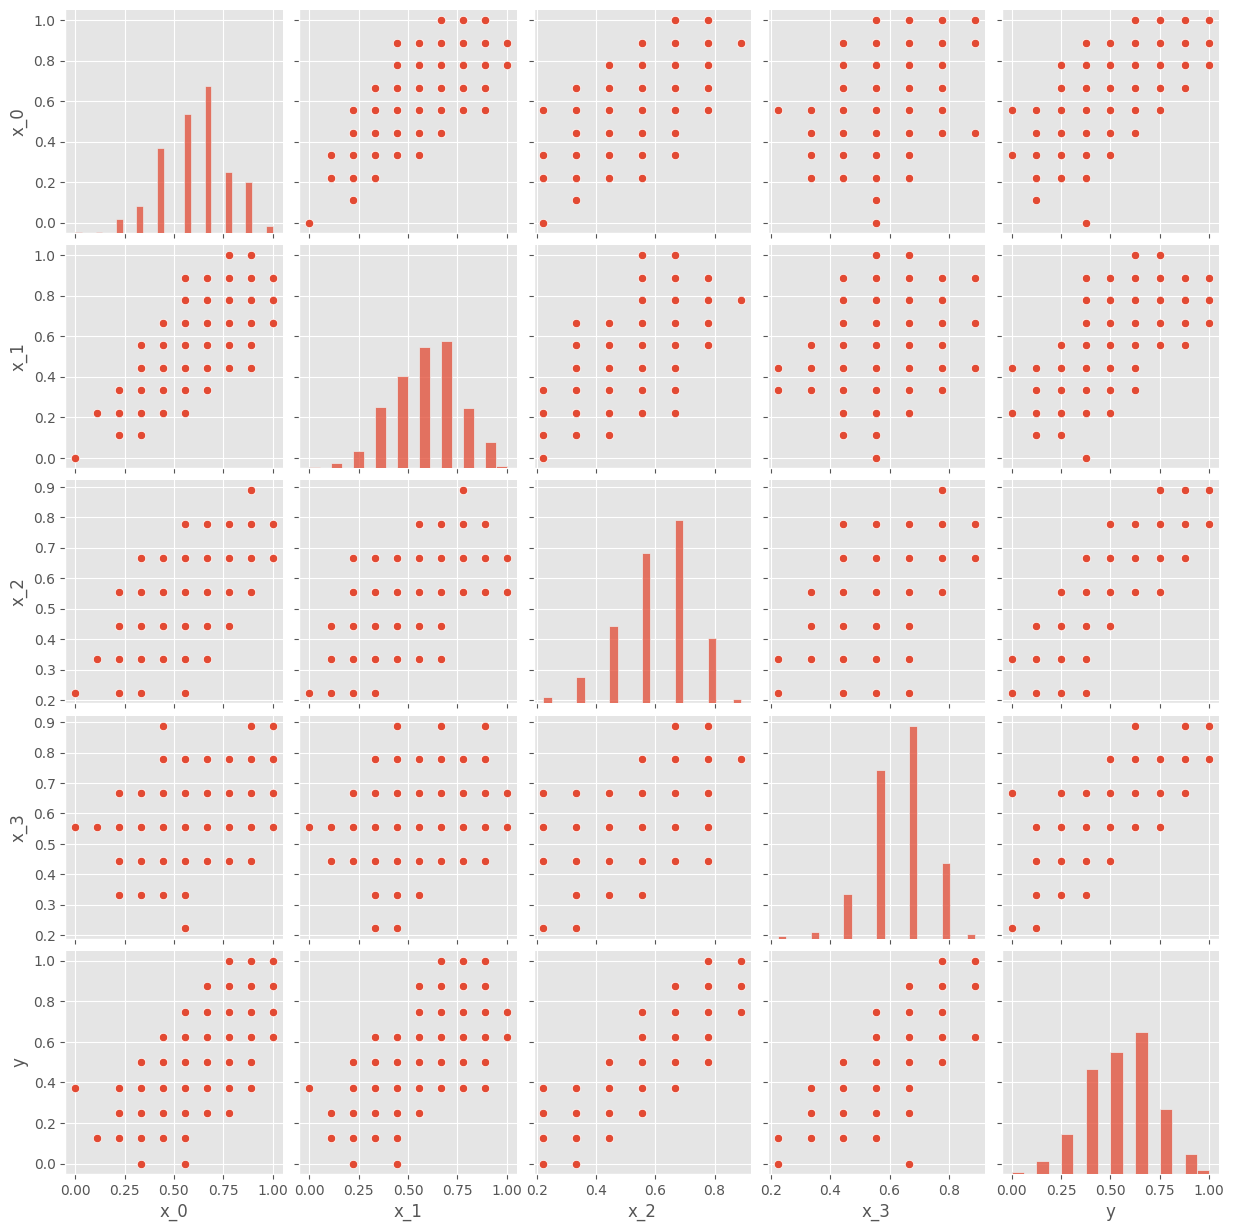

In [13]:
df_train = pd.DataFrame(X_tensor.numpy(),columns = ['x_{}'.format(i) for i in range(len(cols_selected))])
df_train['y']  = y_tensor.numpy()
sns.pairplot(df_train)
plt.show()

# MODELLING

#### NEURAL NETWORK

{'data_load': {'x_lim': [0, 1], 'y_lim': [0, 1]}, 'model_architecture': {'actfunc': ['tanh', 'tanh'], 'batch_size': None, 'layers': [4, 5, 5, 1]}, 'training': {'delta': 0.1, 'delta_external': 0.0, 'delta_synthetic': 0.0, 'epsilon_synthetic': 0.0, 'epsilon': 0.1, 'learning_rate': 0.001, 'monotone_relations': [1, 1, 1, 1], 'n_epochs': 5000, 'patience': 1000, 'plot_history': True, 'save_model': False, 'early_stopping': True, 'std_growth': 0.0, 'verbose': 1, 'weight_decay': 0.005, 'seed': 0, 'optimizer_type': 'Adam'}}
------------------ Training ------------------
Using early stopping


[2297/5000]:  46%|████▌     | 2297/5001 [00:33<00:39, 69.27it/s, Train Loss=0.00526, Train Loss Mod=0.00526, Val Loss=0.00535]


Early stopping at epoch 2297
------------------ Training Results ------------------
2298


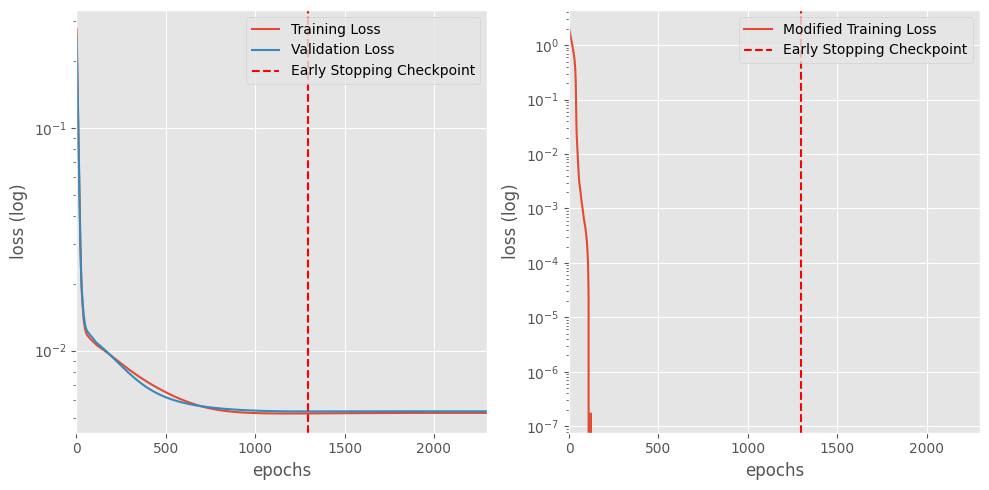

MSE Train: 0.00517, MSE Val: 0.00337, MSE Test: 0.00534
RMSE Train: 0.07189, RMSE Val: 0.05805 , RMSE Test: 0.07308
MAE Train: 0.05356, MAE Val: 0.04399, MAE Test: 0.05444
R2 Train: 0.82696, R2 Val: 0.90176, R2 Test: 0.83488


In [14]:
### CON PENALIZACION
torch.manual_seed(0)
with open('../Scripts/config_rw.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
# Define the path to the folder
folder_path = './Models'
config['model_architecture']['layers'][0] = len(cols_selected)
config['training']['monotone_relations'] = [ 1 for i in range(len(cols_selected))]
print(config)

# Check if the folder exists
if not os.path.exists(folder_path):
    # If it doesn't exist, create it
    os.makedirs(folder_path)
NN_Monotonic = train(config)
model = NN_Monotonic._model
Utils.print_errors(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor,lipschitz_const=0.0,log=False,config=None)

# VORONOI CHECK

In [15]:
### Compute Lipstchiz Constant
## Take one input and output random (it does not matter since the objective is to bound the Hessian for all inputs)
x = train_dataload.dataset.tensors[0][0].view(1,-1)
y = train_dataload.dataset.tensors[1][0].view(1,-1)

weights, biases = utilities_voronoi.get_weights_and_biases(model)
# Just extract the weights and biases from the model independently of the activation functions
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights,
                                                                                          biases, ['identity','sigmoid','sigmoid','identity'],
                                                                                          x, y,sens_end_layer=len(config['model_architecture']['actfunc']))

## Calculate the Hessian for the first input
monotonic_vars = [0,1,2,3]
n_vars = 4
global_lipschitz_constant = utilities_voronoi.hessian_bound(W=W,
                                                            actfunc=config['model_architecture']['actfunc'],
                                                            partial_monotonic_variable=monotonic_vars,
                                                            n_variables=n_vars)
print('Lipschitz Upper Bound: ', global_lipschitz_constant)

Lipschitz Upper Bound:  0.9128339042438006


In [16]:
## Fix seed
torch.manual_seed(1)
np.random.seed(1)

## Select n points randomly
n_points = 10
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
## Filter duplicated values
original_points = np.unique(original_points,axis=0)
## Round original_points
original_points = np.round(original_points,3)
inputs = torch.tensor(original_points,dtype=torch.float)
outputs = []

## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
epsilon = 1e-2
x_lim = [0,1]
y_lim = [0,1]
z_lim = [0,1]
t_lim = [0,1]
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1]), (z_lim[0], z_lim[1]), (t_lim[0],t_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
intervals_extended = [(x - epsilon, y + epsilon) for x, y in intervals]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)


## Compute original Voronoi diagram
original_vor = Voronoi(original_points,incremental=True)

## Compute symmetric points
all_points, _ = utilities_voronoi.add_symmetric_points(original_vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points,incremental=True)

## Compute the radios for each point
start_time = time.time()
radius_tot,dict_radios,x_reentrenamiento,_ = utilities_voronoi.get_lipschitz_radius_neuralsens(inputs=inputs,outputs=outputs,weights=weights,biases=biases,
                                actfunc=config['model_architecture']['actfunc'],global_lipschitz_constant=global_lipschitz_constant,
                                monotone_relation=[1,1,1,1],variable_index=[0,1,2,3],n_variables=4,epsilon_derivative=0.1)
end_time = time.time()
print('Time of execution: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]


## Check if the space is filled
space_filled, distances = utilities_voronoi.check_space_filled_vectorized(finite_vor,dict_radios,vertices)
print('The space is filled: {}'.format(space_filled))


Time of execution: 0.024724721908569336
The space is filled: False


In [17]:
## Add points to the Voronoi diagram
importlib.reload(utilities_voronoi)
x_reentrenamiento = utilities_voronoi.add_points_to_voronoi(original_vor=original_vor,original_points=original_points,finite_vor=finite_vor,dict_radios=dict_radios,
                                        vertices=vertices,distances=distances,model=model,global_lipschitz_constant=global_lipschitz_constant,
                                        actfunc=config['model_architecture']['actfunc'],intervals=intervals,monotone_relations=[1,1,1,1],variable_index=[0,1,2,3],
                                        n_variables=4,plot_voronoi=False, epsilon_derivative = 0.1,
                                        probability=0.0,epsilon=epsilon,max_iterations=1000)

Using NeuralSens


Processing iteration 423:  42%|████▏     | 422/1000 [06:42<09:11,  1.05it/s, Percentage of vertex covered=99.54%, Percentage of Volume Verified=99.87%]

The space is filled: True after 423 iterations 
